In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from random import choices
import os
np.set_printoptions(precision=5, suppress=True)
import time
from numba import jit
from utils import * 
from inference import *
from model import * 

In [2]:
def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    sigma_sq = gamma
    B = np.diagflat([params[5]**2, sigma_sq])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

In [9]:
class EKF_inference(inference):
    
    def __init__(self, convert_params, M):
        self.convert_params = convert_params
        self.M = M 
    
    def _minuslogP(self, params, trajs, dt):
        J, B = self.convert_params(params)
        b = params[4]
        minuslogp = _compute_minuslogP(J, B, self.M, b, trajs, dt)
        return minuslogp
    
    
@jit
def _Q(Qlin, b, p, dt):
    Q = np.copy(Qlin)
    Q[1, 1] -= 3*b*p*p*dt 
    return Q 


@jit
def _rhs(x, J, b): 
    r = J @ x
    r[1] -= b*x[1]**3
    return r 


@jit
def _RK4(x, J, b, dt):
    k1 = _rhs(x, J, b)
    
    x2 = x + k1*dt/2 
    k2 = _rhs(x2, J, b)
    
    x3 = x + k2*dt/2 
    k3 = _rhs(x3, J, b)
    
    x4 = x + dt*k3 
    k4 = _rhs(x4, J, b)
    
    return x + (k1 + 2*k2 + 2*k3 + k4)/6*dt 

@jit
def _compute_minuslogP(J, B, M, b, trajs, dt):
    '''
    traj: 2 x T 
    '''
    invM = np.linalg.inv(M)
    Qlin = J*dt + np.identity(2)
    Bdt = B*dt


    minuslogp = 0 
    for traj in trajs: 
        N = traj.shape[-1]

        V = np.zeros((2, 2))
        x = traj[:, 0]
        for n in range(1, N):
            # compute y_n | x_{n-1}
            xf = _RK4(x, J, b, dt)

            Q = _Q(Qlin, b, x[1], dt)
            Vf = Q @ V @ Q.T + Bdt 

            invCorr = np.linalg.inv(Vf + M)
            _, norm = np.linalg.slogdet(invCorr)

            y = traj[:, n]
            diff = y - xf 
            minuslogp += diff.T @ invCorr @ diff/2
            minuslogp -= norm/2

            # compute x_n | y_n 
            K = Vf @ invCorr
            V = np.linalg.inv(invM+np.linalg.inv(Vf))
            x = xf + K @ diff
    return minuslogp


### Data

In [4]:
path = 'Data/N11_ThetaPola_DATA/'
files = [f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(path+f)['POLA'])
    else: 
        theta_trajs.append(loadmat(path+f)['THETAd'])

N11_1_R200_B30_04_05_POLARIZATION.mat N11_1_R200_B30_04_05_ThetaTime.mat
N11_1_R200_B50_04_05_POLARIZATION.mat N11_1_R200_B50_04_05_ThetaTime.mat
N11_1_R200_B50_25_04_POLARIZATION.mat N11_1_R200_B50_25_04_ThetaTime.mat
N11_1_R200_B50_26_04_POLARIZATION.mat N11_1_R200_B50_26_04_ThetaTime.mat
N11_2_R200_B50_26_04_POLARIZATION.mat N11_2_R200_B50_26_04_ThetaTime.mat
N11_3_R200_B50_25_04_POLARIZATION.mat N11_3_R200_B50_25_04_ThetaTime.mat
N11_4_R200_B100_25_04_POLARIZATION.mat N11_4_R200_B100_25_04_ThetaTime.mat
N11_4_R200_B30_25_04_POLARIZATION.mat N11_4_R200_B30_25_04_ThetaTime.mat
N11_4_R200_B50_25_04_POLARIZATION.mat N11_4_R200_B50_25_04_ThetaTime.mat
N11_5_R200_B30_25_04_POLARIZATION.mat N11_5_R200_B30_25_04_ThetaTime.mat
N11_5_R200_B50_25_04_POLARIZATION.mat N11_5_R200_B50_25_04_ThetaTime.mat


In [5]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))
theta_trajs.pop(2);
pol_trajs.pop(2); 
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]


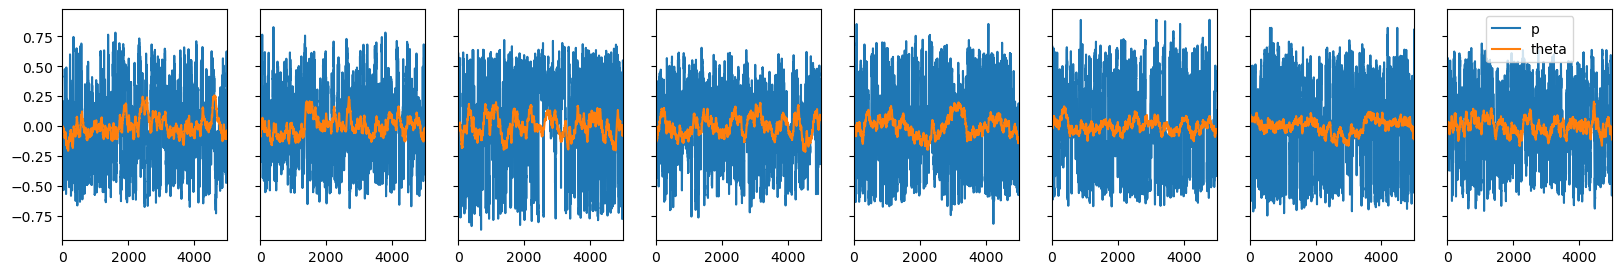

In [6]:
f1 = lambda x: (x[:, 1])/180*np.pi - np.mean(x[:, 1])/180*np.pi
f2 = lambda x: np.mean(x[:, 1:4], axis=1) - np.mean(x[:, 1:4])
f3 = lambda x: np.sin(x[:, 2]) - np.mean(np.sin(x[:, 2]))
data = [np.stack([f1(theta), f3(p)]) for (theta, p) in zip(theta_trajs, pol_trajs)]
dt = 0.03333333333333333
show([d for d in data if len(d[0]) == 5000])

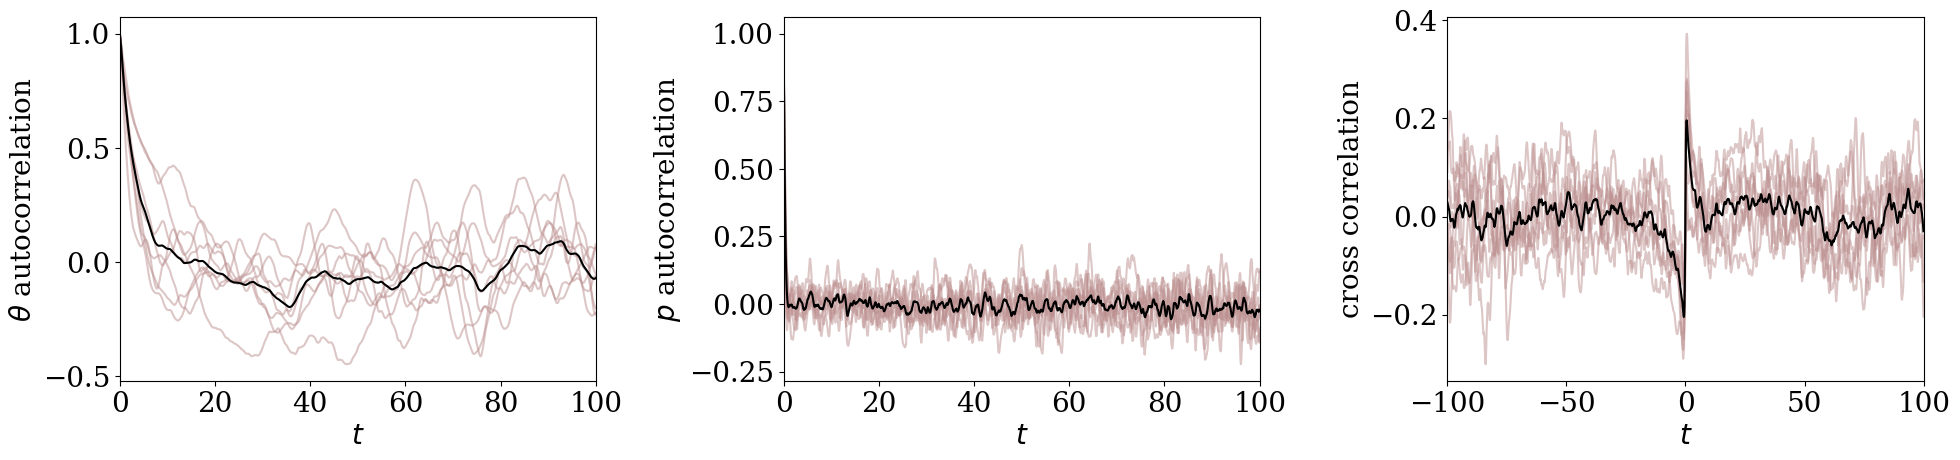

In [7]:
plot_corr([d for d in data if len(d[0]) == 5000], 3000, dt, colors=['rosybrown', 'black']); 

In [8]:
gamma = 1
c = 78/(4/gamma)
mu = 0.1
epsilon = 0.256
beta = 88/(4/gamma)
guess = [epsilon, gamma, mu, c, beta, 0.03]

In [34]:
bounds = [[0, None]]*6
dt = 0.03333333333333333

MAPs = [] 
indices = [] 

index_array = np.arange(len(data))

M = np.diagflat([0.002, 0.04])**2 # measurement noise 
inf = EKF_inference(convert_params, M)

with open('bootstrap_output.txt', 'w') as file: 

    for i in range(100): 

        # first, resample the data 
        ind = np.random.choice(index_array, len(data))
        resampled_data = [data[index] for index in ind]
        
        t1 = time.time() 
        MAP, y = inf.inf(guess, resampled_data, dt, bounds=bounds)
        t2 = time.time() 
        print('{}th sample, time taken: '.format(i), t2-t1)
        MAPs.append(MAP)
        indices.append(ind)
        
        file.write('{}\n'.format(np.array2string(ind, separator=',')))
        file.write('{}\n'.format(np.array2string(MAP, separator=',')))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


0th sample, time taken:  174.3812699317932
1th sample, time taken:  141.10889887809753
2th sample, time taken:  139.05404114723206
3th sample, time taken:  186.27930188179016
4th sample, time taken:  103.45931386947632
5th sample, time taken:  340.36265301704407
6th sample, time taken:  136.95747923851013
7th sample, time taken:  202.18003702163696
8th sample, time taken:  258.0608971118927
9th sample, time taken:  116.34972596168518
10th sample, time taken:  137.97850012779236
11th sample, time taken:  118.1029040813446
12th sample, time taken:  178.21037602424622
13th sample, time taken:  66.80993580818176
14th sample, time taken:  122.84001588821411
15th sample, time taken:  81.48956274986267
16th sample, time taken:  144.18282794952393
17th sample, time taken:  428.97175097465515
18th sample, time taken:  85.10719895362854
19th sample, time taken:  551.5413858890533
20th sample, time taken:  221.0917820930481
21th sample, time taken:  338.5909380912781
22th sample, time taken:  153

In [81]:
MAP = np.mean(MAPs, axis=0)
std_err = np.std(MAPs, axis=0)
print('MAP: ', MAP)
print('std_err: ', std_err)

MAP:  [ 0.09872  0.42583  0.18864  5.78463 12.51193  0.02366]
std_err:  [0.02064 0.06515 0.02015 0.27197 1.24794 0.00028]


In [103]:
guess = np.copy(MAP)

n_frames = 5000
dt = 0.03333333333333333 
m = FHN(guess, convert_params)
print(np.linalg.eigvals(m.J))
n_repeats = 8
sims = m.evolve(n_frames*dt, 6.6e-3, n_frames, n_repeats)

[0.08778 0.4789 ]


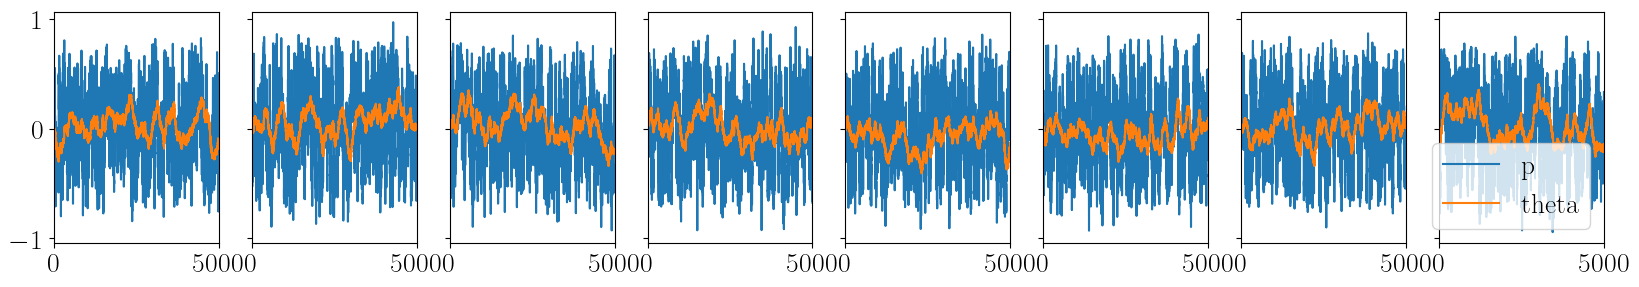

In [104]:
show(sims)

(<Figure size 2000x600 with 4 Axes>,
 array([<Axes: xlabel='$\\theta$', ylabel='$P(\\theta)$'>,
        <Axes: xlabel='$p$', ylabel='$P(p)$'>,
        <Axes: xlabel='$\\theta$', ylabel='$p$'>], dtype=object))

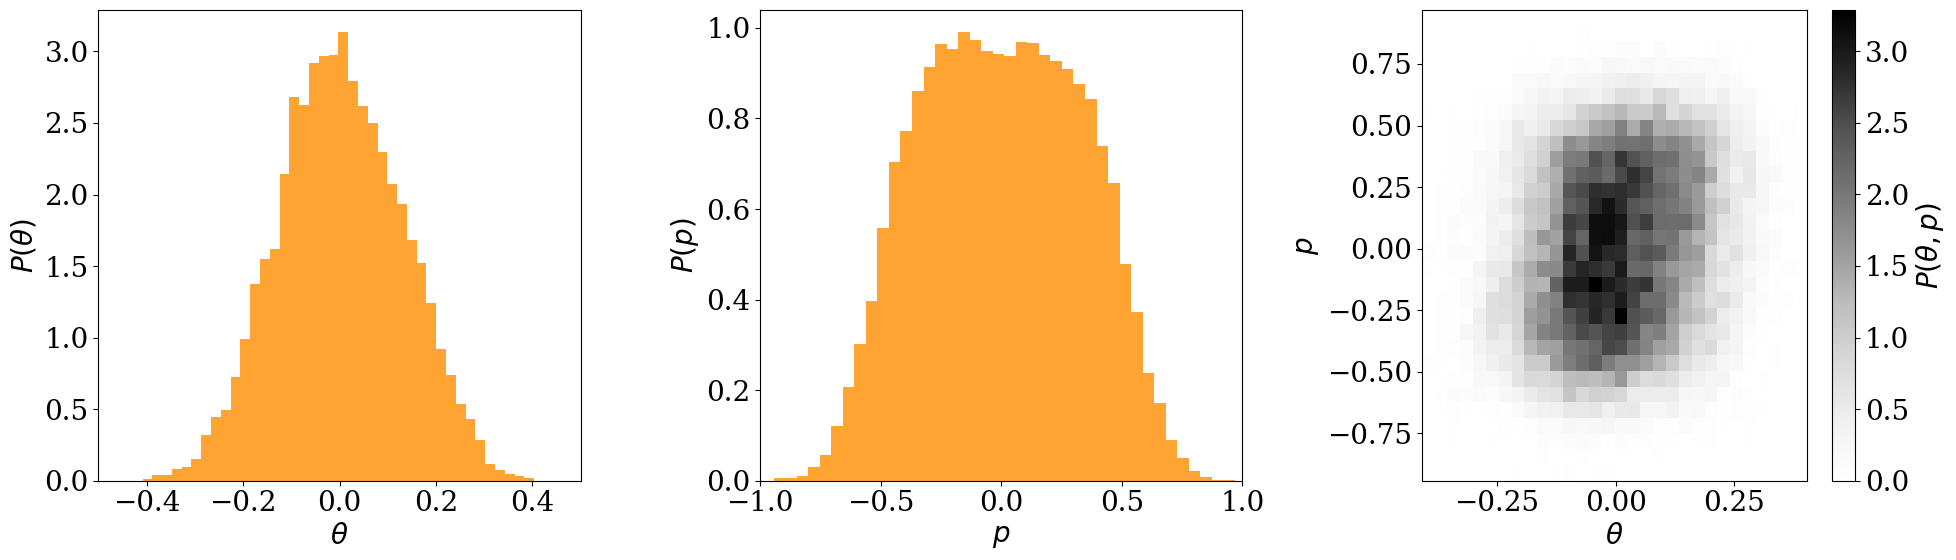

In [105]:
plot_overall_dist(sims)

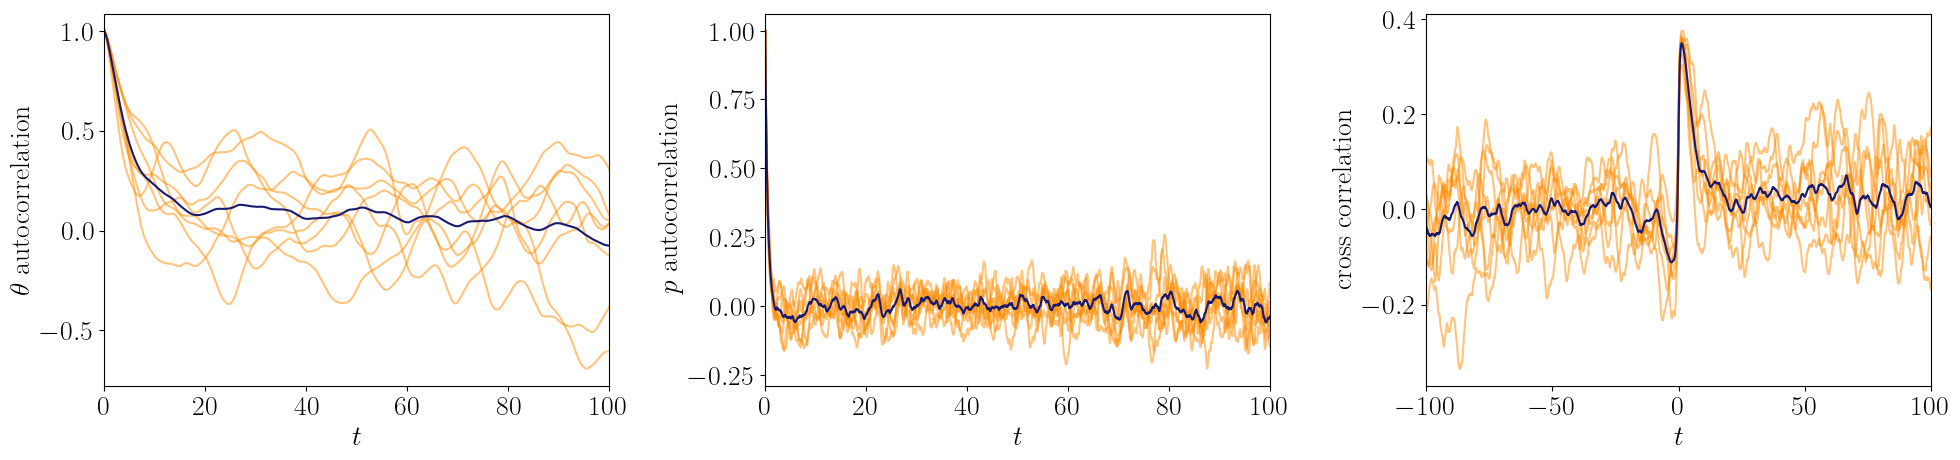

In [107]:
_, _, cc = plot_corr(sims, 3000, dt, norm=True, tex=True); 
plt.savefig('Figures/br_corr.pdf')
plt.show() 

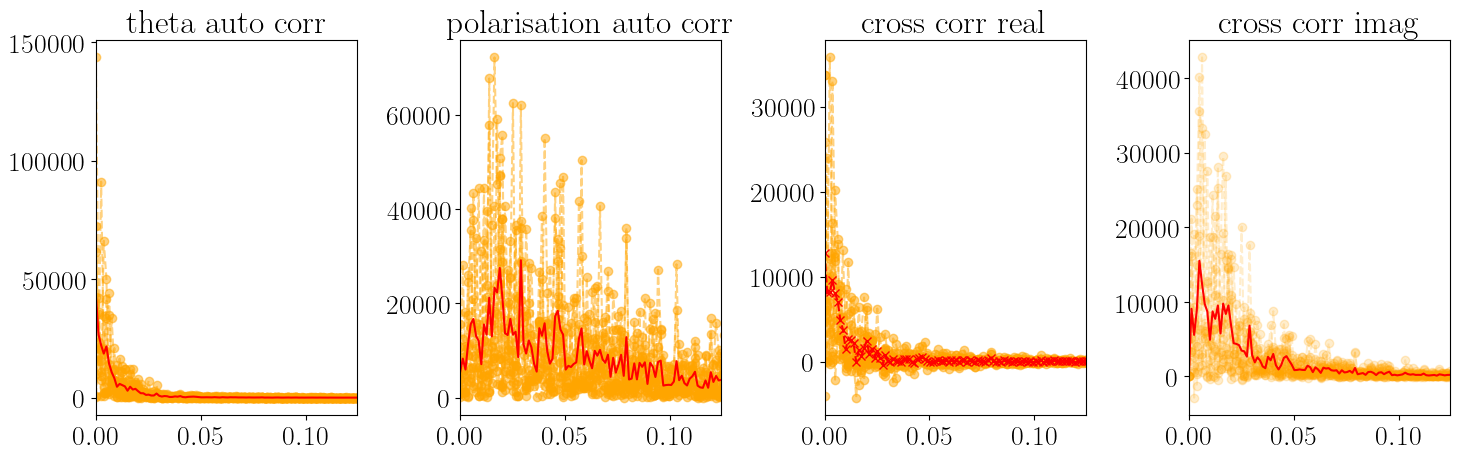

(array([43228.96712, 26629.6603 , 22072.4663 , ...,     0.89378,
            0.57755,     0.475  ]),
 array([5494.96105, 8273.02038, 5961.67338, ...,   59.95501,   87.52523,
          80.47751]),
 array([12821.85138   +0.j     ,  8198.75765+9081.83158j,
         8248.34604+5576.06949j, ...,     0.27819   -2.14477j,
           -2.45897   +0.09598j,    -2.71001   +0.j     ]))

In [108]:
plot_corr_ft(np.array(sims), dt)